The model takes a sequence of numbers as input (e.g., [1, 2, 3]) and predicts the reversed sequence (e.g., [3, 2, 1]).

Epoch 1/20
157/157 [==============================] - 5s 8ms/step - loss: 1.7276 - accuracy: 0.3590
Epoch 2/20
157/157 [==============================] - 1s 7ms/step - loss: 0.8287 - accuracy: 0.7311
Epoch 3/20
157/157 [==============================] - 1s 8ms/step - loss: 0.2921 - accuracy: 0.9674
Epoch 4/20
157/157 [==============================] - 1s 7ms/step - loss: 0.1207 - accuracy: 0.9965
Epoch 5/20
157/157 [==============================] - 1s 8ms/step - loss: 0.0635 - accuracy: 0.9994
Epoch 6/20
157/157 [==============================] - 1s 8ms/step - loss: 0.0388 - accuracy: 0.9998
Epoch 7/20
157/157 [==============================] - 1s 9ms/step - loss: 0.0253 - accuracy: 1.0000
Epoch 8/20
157/157 [==============================] - 1s 9ms/step - loss: 0.0181 - accuracy: 1.0000
Epoch 9/20
157/157 [==============================] - 1s 9ms/step - loss: 0.0134 - accuracy: 1.0000
Epoch 10/20
157/157 [==============================] - 1s 8ms/step - loss: 0.0102 - accuracy: 1.0000

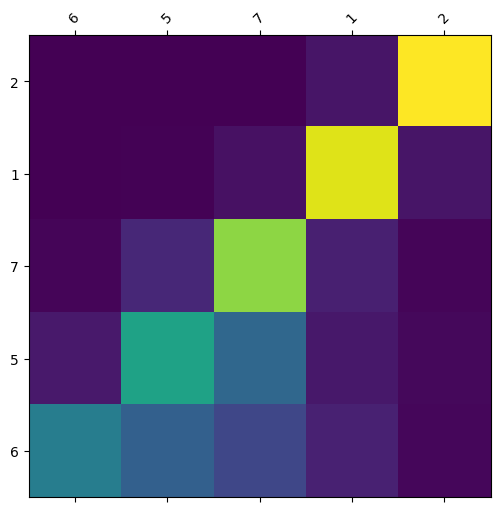

In [3]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dot, Activation, Concatenate
import matplotlib.pyplot as plt

# Generate the data
num_samples = 10000  # Number of sequences
input_length = 5     # Length of each input sequence
input_vocab_size = 10  # Vocabulary size (digits 0-9)

# Generate random input sequences
input_sequences = np.random.randint(1, input_vocab_size, (num_samples, input_length))
target_sequences = np.flip(input_sequences, axis=1)  # Reverse the sequences for the target

# One-hot encode the input and target sequences
input_onehot = np.eye(input_vocab_size)[input_sequences]
target_onehot = np.eye(input_vocab_size)[target_sequences]

# Prepare decoder input sequences (shifted target sequences)
decoder_input_sequences = np.zeros_like(target_onehot)
decoder_input_sequences[:, 1:, :] = target_onehot[:, :-1, :]  # Shift target sequences to the right
decoder_input_sequences[:, 0, :] = 0  # Set <start> token as all zeros

# Define the Encoder
encoder_inputs = Input(shape=(None, input_vocab_size))
encoder_lstm = LSTM(64, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# Define the Decoder
decoder_inputs = Input(shape=(None, input_vocab_size))
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Attention Mechanism
attention = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])  # Compute similarity scores
attention = Activation('softmax')(attention)  # Normalize scores to probabilities
context = Dot(axes=[2, 1])([attention, encoder_outputs])  # Weighted sum of encoder outputs

# Concatenate context vector with decoder LSTM outputs
decoder_combined_context = Concatenate(axis=-1)([context, decoder_outputs])

# Final output layer
decoder_dense = Dense(input_vocab_size, activation='softmax')
final_outputs = decoder_dense(decoder_combined_context)

# Define the full model
model = Model([encoder_inputs, decoder_inputs], final_outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit([input_onehot, decoder_input_sequences], target_onehot, epochs=20, batch_size=64, verbose=1)

# Define the inference models
# Encoder inference model
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Decoder inference model
decoder_state_input_h = Input(shape=(64,))
decoder_state_input_c = Input(shape=(64,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_state_input = Input(shape=(input_length, 64))  # Encoder outputs

decoder_lstm_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
attention = Dot(axes=[2, 2])([decoder_lstm_outputs, decoder_hidden_state_input])
attention = Activation('softmax')(attention)
context = Dot(axes=[2, 1])([attention, decoder_hidden_state_input])
decoder_combined_context = Concatenate(axis=-1)([context, decoder_lstm_outputs])
decoder_outputs = decoder_dense(decoder_combined_context)

decoder_model = Model(
    [decoder_inputs, decoder_hidden_state_input] + decoder_states_inputs,
    [decoder_outputs, attention, state_h, state_c]
)

# Function to decode a sequence
def decode_sequence(input_seq):
    # Encode the input sequence
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)

    # Create an empty target sequence with a <start> token (all zeros)
    target_seq = np.zeros((1, 1, input_vocab_size))

    # Initialize the decoded sequence
    decoded_sequence = []
    attention_weights = []

    # Generate tokens one-by-one
    for _ in range(input_length):
        # Predict the next token
        output_tokens, att_weights, h, c = decoder_model.predict(
            [target_seq, encoder_outputs, state_h, state_c]
        )

        # Save attention weights for visualization
        attention_weights.append(att_weights[0])

        # Get the token with the highest probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        decoded_sequence.append(sampled_token_index)

        # Update the target sequence (input to the next step of the decoder)
        target_seq = np.zeros((1, 1, input_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1

        # Update the decoder's states
        state_h, state_c = h, c

    return decoded_sequence, np.array(attention_weights)

# Visualize attention weights
def plot_attention(input_seq, attention_weights, decoded_seq):
    fig, ax = plt.subplots(figsize=(10, 6))
    attention_weights = attention_weights.squeeze()
    ax.matshow(attention_weights, cmap='viridis')
    ax.set_xticks(range(len(input_seq[0])))
    ax.set_yticks(range(len(decoded_seq)))
    ax.set_xticklabels(input_seq[0], rotation=45)
    ax.set_yticklabels(decoded_seq)
    plt.show()

# Test the model with a new input
test_sequence = np.random.randint(1, input_vocab_size, (1, input_length))  # Single test sequence
test_sequence_onehot = np.eye(input_vocab_size)[test_sequence]  # One-hot encode the input
decoded_output, att_weights = decode_sequence(test_sequence_onehot)

# Print the results
print("Input sequence:", test_sequence[0])  # Original input sequence
print("Decoded sequence:", decoded_output)  # Reversed sequence predicted by the model

# Visualize attention weights
plot_attention(test_sequence, att_weights, decoded_output)


The above heatmap shows how the attention weights changed for each decoding step.